In [1]:
import numpy as np
import jax.numpy as jnp
from pathlib import Path
from importlib import reload

In [2]:
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

# figure aesthetics
plt.style.use(["../utils/dark.mplstyle","../utils/notebook.mplstyle"])  # for dark themes
# plt.style.use(['seaborn-notebook'])

In [3]:
# custom libraries
import sys, os

sys.path.append(os.path.abspath('../../spaths'))
import spaths

sys.path.append(os.path.abspath('..'))
from sf_nets.utils import dmaps

# Hidden linear system

We use a linear 2D slow-fast system. The slow variable drifts larger with constant rate and constant amount of fluctuation. The fast variable follows the value of the slow one.

In [4]:
eps = .001

# underlying linear process coefficients
def drift_lin(t, u, du):
    du[0] = 1.0
    du[1] = (u[0] - u[1]) / eps

def dispersion_lin(t, u, du):
    du[0,0] = 1.0 #/ np.sqrt(100.0)
    du[1,1] = 1.0 / np.sqrt(eps)

sde_lin = spaths.ItoSDE(drift_lin, dispersion_lin, noise_mixing_dim=2)

In [5]:
# seed setting and solver
seed = 3579
rng = np.random.default_rng(seed)
rng.integers(10**3);  # warm up of RNG

# stochastic solver
em = spaths.EulerMaruyama(rng)

In [6]:
# simulation params
dt = eps / 5
x0, y0 = 0.0, 0.0
tspan = (0.0, 10.0)

In [7]:
ens0 = np.array([[x0,y0]]) #spaths.make_ens(x0, y0)
sol_lin = em.solve(sde_lin, ens0, tspan, dt)

In [8]:
sol_lin.p.shape

(1, 50001, 2)

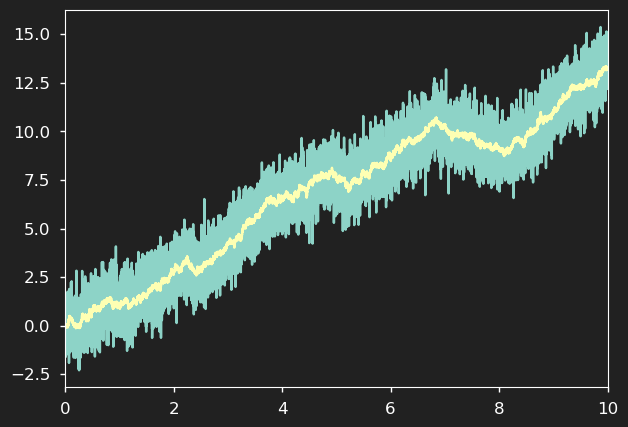

In [9]:
path = sol_lin.p[0]
plt.plot(sol_lin.t, path.T[1])
plt.plot(sol_lin.t, path.T[0])
plt.xlim(tspan);

## Data from linear system

In [10]:
data = path[1::10].astype(np.float32)
time = sol_lin.t[1::10].astype(np.float32)
print(f"{data.shape = }")
print(f"{data.dtype = }")

data.shape = (5000, 2)
data.dtype = dtype('float32')


In [11]:
colors = ['#8dd3c7', '#feffb3', '#fa8174']
cmap1 = mpl.colors.LinearSegmentedColormap.from_list("mycmap", colors)

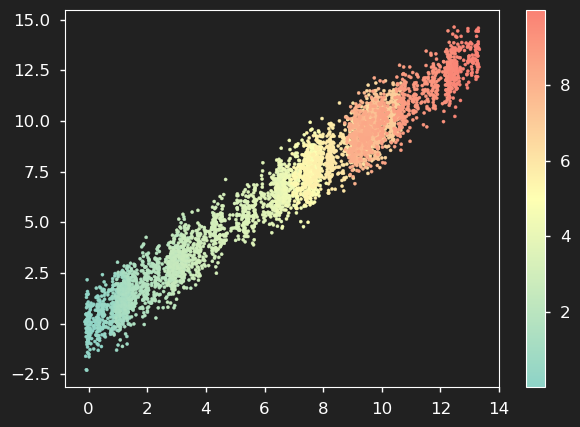

In [12]:
# plt.figure(figsize=(10,7))
sc = plt.scatter(*data.T, s=5, c=time, cmap=cmap1)
plt.colorbar();
# u = np.linspace(min(data.T[0]), max(data.T[0]), 100)
# # u = np.linspace(0, 3, 100)
# plt.plot(u, u, c='C1');
# for u0 in u[::5]:
#     u = 50*[u0]
#     v = np.linspace(u0-1.5, u0+1.5, 50)
#     plt.plot(u, v, color='C3');

# Observed data & system

## Transformation of data

In [13]:
ff = lambda r: +jnp.sin(.5*np.pi*r)
df = lambda r: +jnp.cos(.5*np.pi*r) * (.5*np.pi)
hf = lambda r: -jnp.sin(.5*np.pi*r) * (.5*np.pi)**2

In [14]:
# transformation and its inverse
F = lambda v, w: (v - w + ff(w), w)
G = lambda y, z: (y + z - ff(z), z)

In [15]:
# array verions
fwdF = lambda u: jnp.array(F(*u))  # u = (v, w)
bwdF = lambda x: jnp.array(G(*x))  # x = (y, z)

In [16]:
np.allclose(bwdF(fwdF(data.T)), data.T)

True

In [17]:
Fdata = fwdF(data.T).T
# Fdata = rng.permutation(Fdata)  # results do not depend on time relation

In [18]:
print(f"{Fdata.shape = }")
print(f"{Fdata.dtype = }")

Fdata.shape = (5000, 2)
Fdata.dtype = dtype('float32')


In [19]:
np.allclose(fwdF(bwdF(Fdata.T)), Fdata.T, atol=1e-6)

True

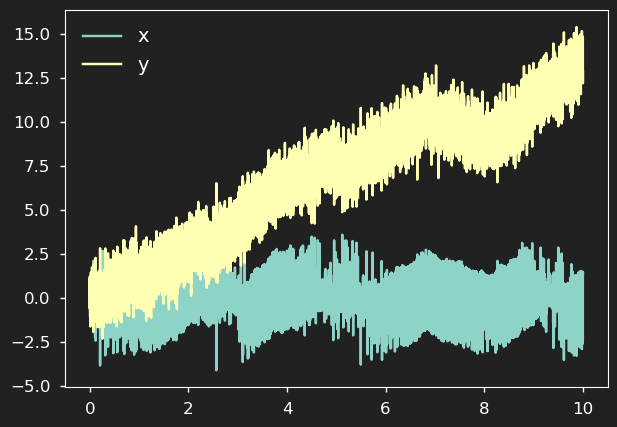

In [20]:
Fpath = fwdF(path.T).T
plt.plot(sol_lin.t, Fpath.T[0], label='x')
plt.plot(sol_lin.t, Fpath.T[1], label='y')
plt.legend();

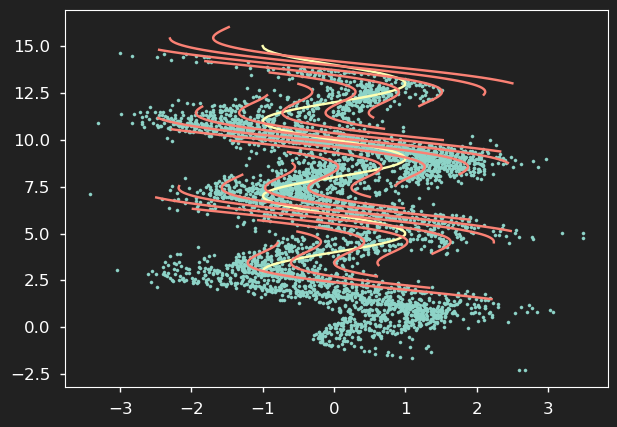

In [21]:
# plt.figure(figsize=(10,7))

u = np.linspace(3, 15, 100)
spine = F(u, u)
plt.plot(*spine, c='C1');

fibers = []
for u0 in u[::5]:
    v = np.linspace(u0-1.5, u0+1.5, 50)
    fibers.append(F(u0, v))
    plt.plot(*F(u0, v), color='C3')
plt.scatter(*Fdata.T, s=5);

## Transformation of underlying SDE

In [22]:
Fens0 = fwdF(ens0.T).T

### Direct formulas

In [92]:
def drift_Flin(t, x, dx):
    y, z = x
    dx[0] = ( eps + (df(z)-1.0)*(y-ff(z)) + .5*hf(z) ) / eps
    dx[1] = (y-ff(z)) / eps

def dispersion_Flin(t, x, dx):
    y, z = x
    dx[0,0] = 1.0
    dx[1,0] = (df(z)-1.0) / np.sqrt(eps)
    dx[1,1] = 1.0 / np.sqrt(eps)

sde_Flin = spaths.ItoSDE(drift_Flin, dispersion_Flin, noise_mixing_dim=2)

In [93]:
sol_Fsde = em.solve(sde_Flin, Fens0, tspan, dt)

np.any(Fpath == np.nan) = False


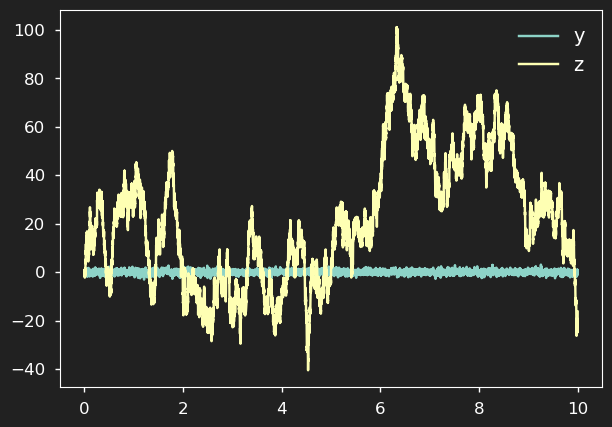

In [94]:
Ftimes = sol_Fsde.t
Fpath = sol_Fsde.p[0]
print(f"{np.any(Fpath == np.nan) = }")
plt.plot(Ftimes, Fpath.T[0], label="y")
plt.plot(Ftimes, Fpath.T[1], label="z")
plt.legend()
plt.show()

In [95]:
y, z = Fpath.T
z = np.mod(z, 4.0)
path = np.array([y, z]).T

In [98]:
Fdata = Fpath[1::20].astype(np.float32)
print(f"{data.shape = }")
print(f"{data.dtype = }")

data.shape = (5000, 2)
data.dtype = dtype('float32')


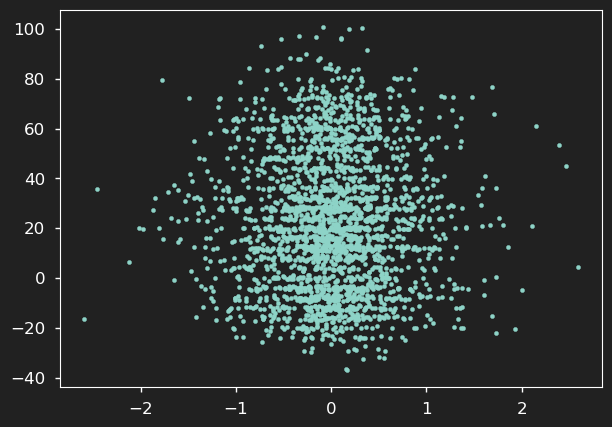

In [99]:
plt.scatter(*Fdata.T);

## Sampling slow manifold

In [47]:
def plot_sman(data, sde, nreps, tspan, dt, c=None):
    ens0 = np.repeat(data, nreps, axis=0)
    nsteps = int(tspan[1]/dt)
    bursts = em.burst(sde, ens0, (0, nsteps), dt).reshape(len(data), nreps, 2)
    slow_means = np.nanmean(bursts, axis=1)
    plt.scatter(*slow_means.T, c=c, s=10)
    
    return slow_means

In [48]:
nreps = 350

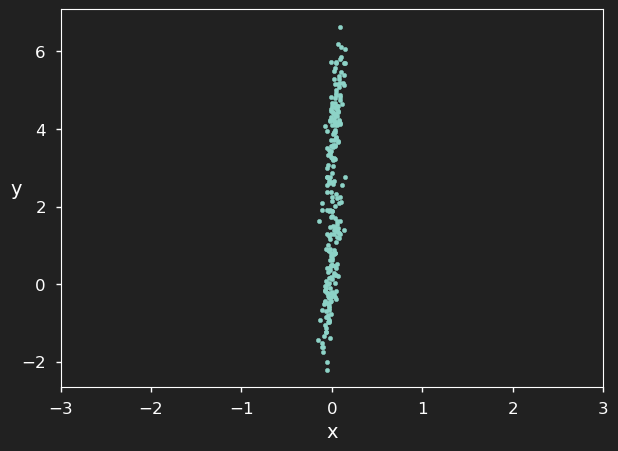

In [49]:
plot_sman(Fdata[::10], sde_Flin, nreps, (0, 6*eps), dt/2)
plt.xlabel("x")
plt.ylabel("y", rotation=0)
plt.xlim([-3,3])
# plt.ylim([-2,2])
plt.show()

## Short trajectories along fibers

In [50]:
def plot_fibs(data, sde, tspan, dt, c=None):
    fib_paths = em.solve(sde, data, tspan, dt).p
    for fib_path in fib_paths:
        plt.scatter(*fib_path.T, s=7, c=c);

In [73]:
ns = 5
xs = np.ones(ns)*3
ys = np.linspace(0, 4, ns)
ds = np.array([xs, ys]).T

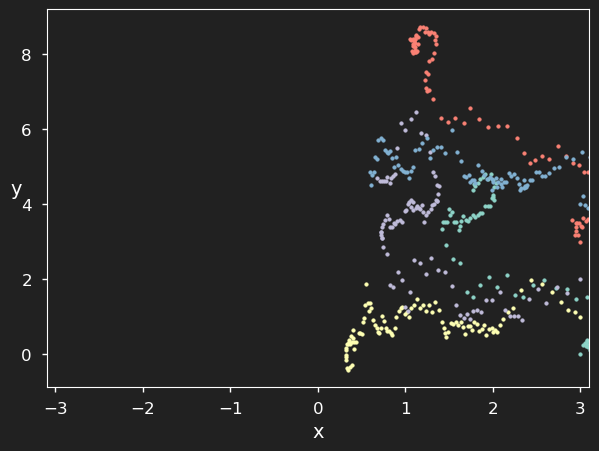

In [77]:
plot_fibs(ds, sde_Flin, (0, 2*eps), dt/10)
plt.xlabel("x")
plt.ylabel("y", rotation=0)
plt.xlim([-3.1,3.1])
# plt.ylim([-2,2])
plt.show()

### SDE transform

In [78]:
Ftransform = spaths.SDETransform(fwdF, bwdF)
Fsde_lin = Ftransform(sde_lin)

In [79]:
sol_Fsde = em.solve(Fsde_lin, Fens0, (0, 4), dt/2)

np.any(Fpath == np.nan) = False


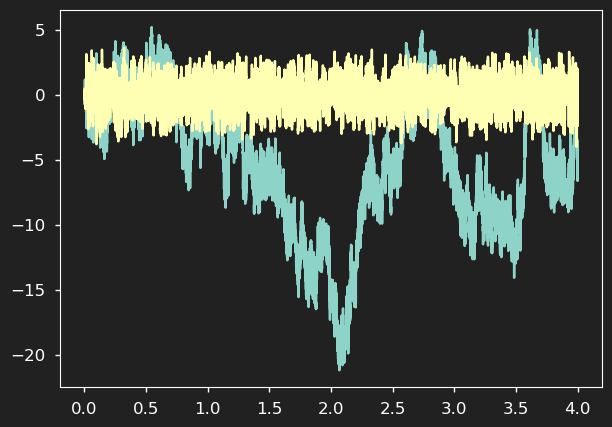

In [80]:
Ftimes = sol_Fsde.t
Fpath = sol_Fsde.p[0]
print(f"{np.any(Fpath == np.nan) = }")
plt.plot(Ftimes, Fpath.T[1])
plt.plot(Ftimes, Fpath.T[0]);

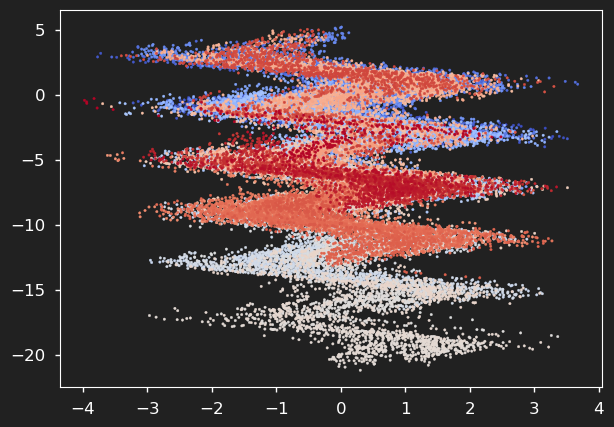

In [81]:
plt.scatter(*Fpath.T, s=3, c=Ftimes);

In [82]:
y, z = Fpath.T
z = np.mod(z, 4.0)
path = np.array([y, z]).T

In [83]:
Fdata = path[1::20].astype(np.float32)
print(f"{data.shape = }")
print(f"{data.dtype = }")

data.shape = (5000, 2)
data.dtype = dtype('float32')


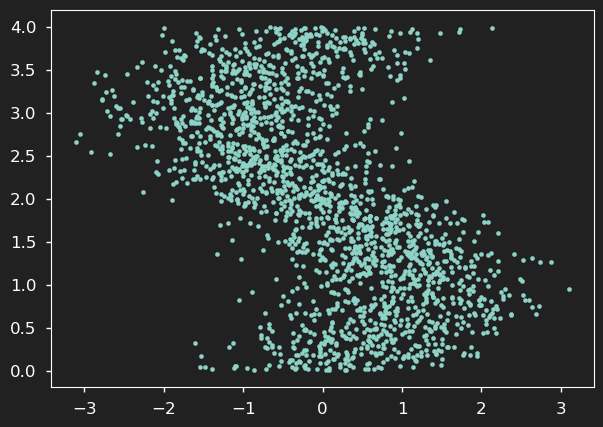

In [84]:
plt.scatter(*Fdata.T)
plt.ylim([0,4])
plt.show